## Predicting and Explaining Customer Churn: A Data Science Approach with Causal Inference Insights

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler


In [2]:
churn = pd.read_csv('Customer_churn.csv')
churn.head()

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value,Churn
0,8,0,38,0,4370,71,5,17,3,1,1,30,197.640,0
1,0,0,39,0,318,5,7,4,2,1,2,25,46.035,0
2,10,0,37,0,2453,60,359,24,3,1,1,30,1536.520,0
3,10,0,38,0,4198,66,1,35,1,1,1,15,240.020,0
4,3,0,38,0,2393,58,2,33,1,1,1,15,145.805,0


## Exploratory Data Analysis

In [3]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Call  Failure            3150 non-null   int64  
 1   Complains                3150 non-null   int64  
 2   Subscription  Length     3150 non-null   int64  
 3   Charge  Amount           3150 non-null   int64  
 4   Seconds of Use           3150 non-null   int64  
 5   Frequency of use         3150 non-null   int64  
 6   Frequency of SMS         3150 non-null   int64  
 7   Distinct Called Numbers  3150 non-null   int64  
 8   Age Group                3150 non-null   int64  
 9   Tariff Plan              3150 non-null   int64  
 10  Status                   3150 non-null   int64  
 11  Age                      3150 non-null   int64  
 12  Customer Value           3150 non-null   float64
 13  Churn                    3150 non-null   int64  
dtypes: float64(1), int64(13)

In [4]:
# Rename columns with spaces
churn.columns = churn.columns.str.replace(' ', '')


In [5]:
# Check for missing values
print(churn.isnull().sum())

CallFailure              0
Complains                0
SubscriptionLength       0
ChargeAmount             0
SecondsofUse             0
Frequencyofuse           0
FrequencyofSMS           0
DistinctCalledNumbers    0
AgeGroup                 0
TariffPlan               0
Status                   0
Age                      0
CustomerValue            0
Churn                    0
dtype: int64


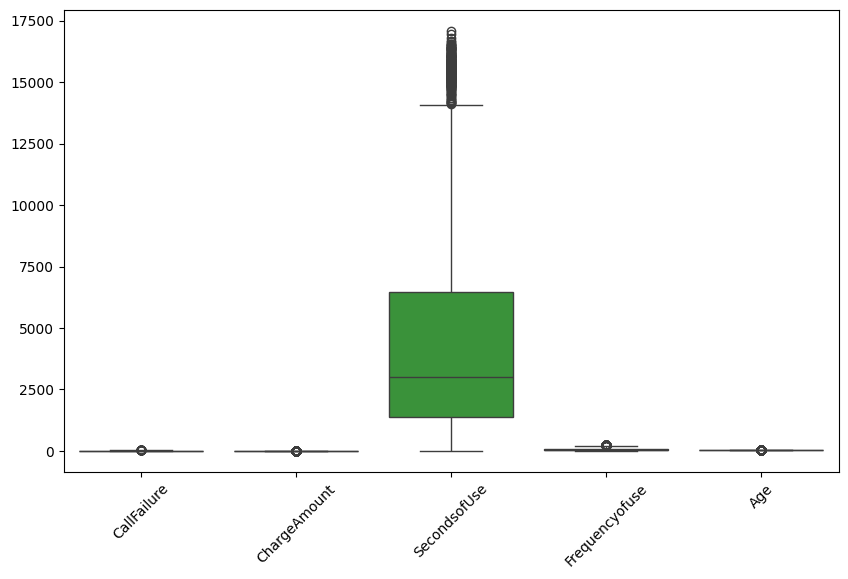

In [6]:
# Boxplots to identify outliers in the numerical columns. 
# Outliers can distort model performance and impact predictions.

plt.figure(figsize=(10, 6))
sns.boxplot(data=churn[['CallFailure', 'ChargeAmount', 'SecondsofUse', 'Frequencyofuse', 'Age']])
plt.xticks(rotation=45)
plt.show()


Seconds of Use shows a broad distribution with several outliers above 15,000 seconds. However its large values make the other factors appear to have tight distributions. Let's rescale it to hours of use and see what the plots look like.

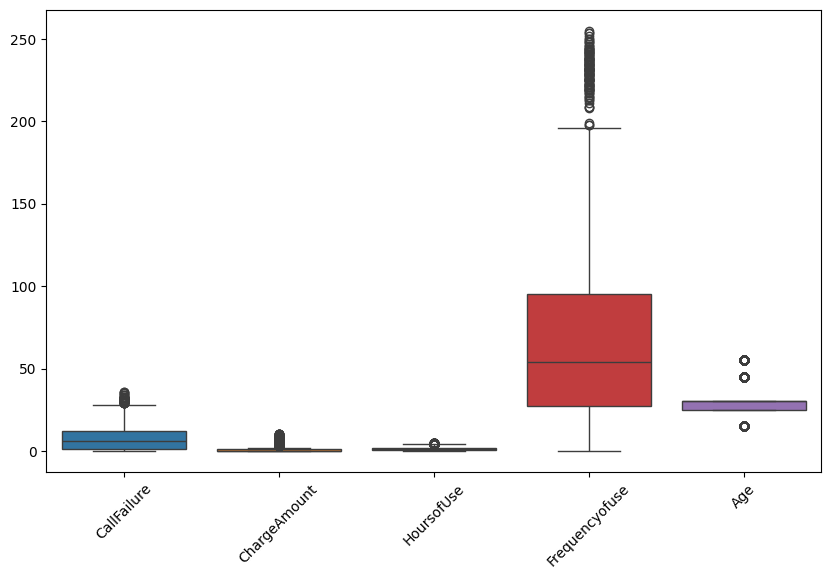

In [7]:
# Boxplots to identify outliers in the numerical columns. 
# Outliers can distort model performance and impact predictions.
churn['HoursofUse']=churn['SecondsofUse']/3600
plt.figure(figsize=(10, 6))
sns.boxplot(data=churn[['CallFailure', 'ChargeAmount', 'HoursofUse', 'Frequencyofuse', 'Age']])
plt.xticks(rotation=45)
plt.show()

 <br>
Other features such as Call Failure, Charge Amount, Frequency of Use, and Age have tight distributions, with potential outliers.

### 2. Univariate Analysis

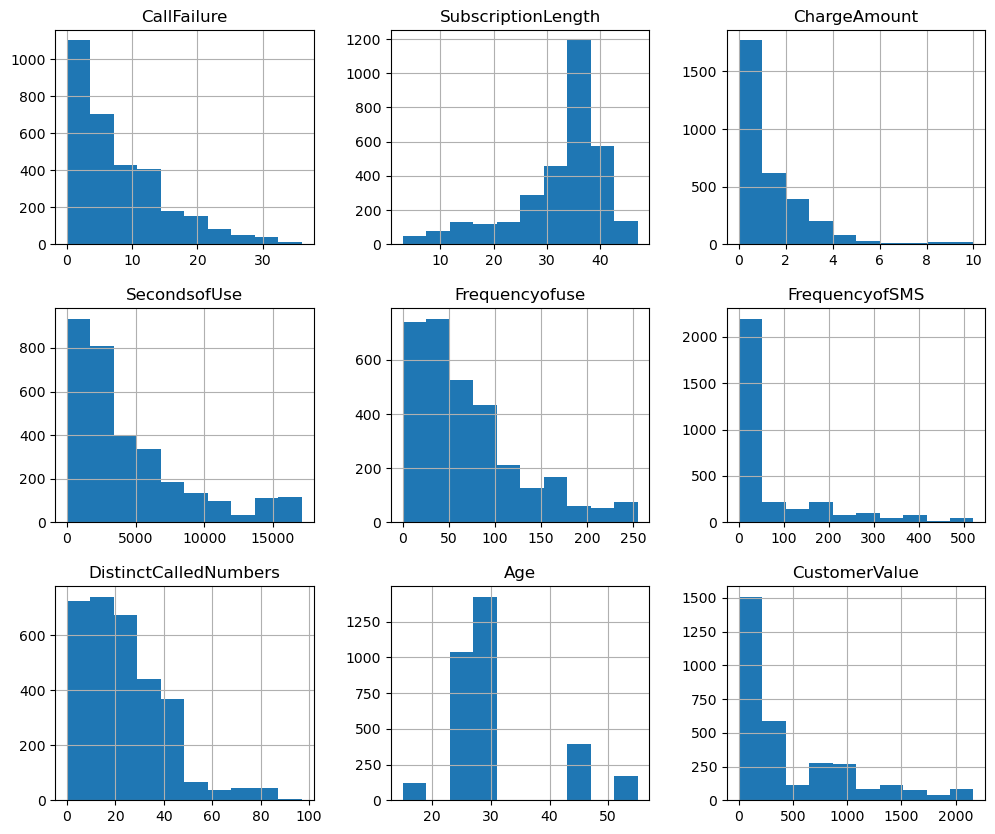

In [7]:
# Plot histograms for numerical features
churn[['CallFailure', 'SubscriptionLength', 'ChargeAmount', 
       'SecondsofUse', 'Frequencyofuse','FrequencyofSMS', 
       'DistinctCalledNumbers', 'Age', 'CustomerValue']].hist(bins=10, figsize=(12, 10))
plt.show()


* Call Failure is highly skewed, with most customers having very few call failures.
Subscription Length shows a peak around 30-40 months.
* Charge Amount and Seconds of Use are right-skewed, indicating that most customers incur low charges and usage times, with a few having high values.
* Frequency of Use and Age also exhibit right-skewed distributions, with most customers clustered towards the lower end.

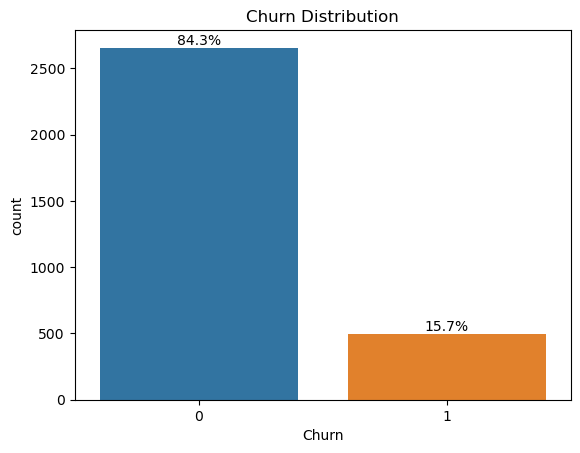

In [8]:
# Plot the churn distribution
ax = sns.countplot(x='Churn', data=churn)
plt.title('Churn Distribution')

# Calculate percentages and add them to the bars
total = len(churn)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    ax.text(p.get_x() + p.get_width() / 2, p.get_height(), percentage, 
            ha='center', va='bottom')

plt.show()

The majority of customers did not churn __(84.3%)__, while a smaller proportion __(15.7%)__ of customers churned. 

### 3. Bivariate Analysis

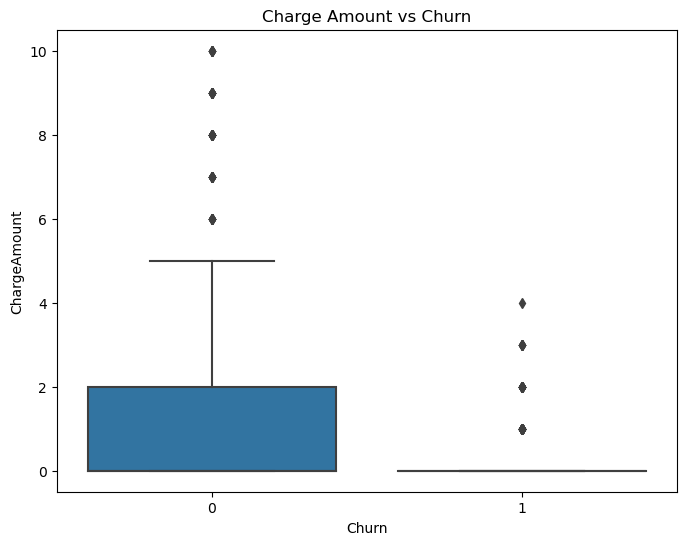

In [9]:
# Boxplot to show relationship between 'Charge Amount' and 'Churn'
plt.figure(figsize=(8, 6))
sns.boxplot(x='Churn', y='ChargeAmount', data=churn)
plt.title('Charge Amount vs Churn')
plt.show()


The box plot above shows that charge amounts for non-churned customers (Churn=0) tend to be higher than those for churned customers (Churn=1). Additionally, the plot indicates a greater variability in charge amounts among churned customers, suggesting a wider range of charging practices or customer behaviors.

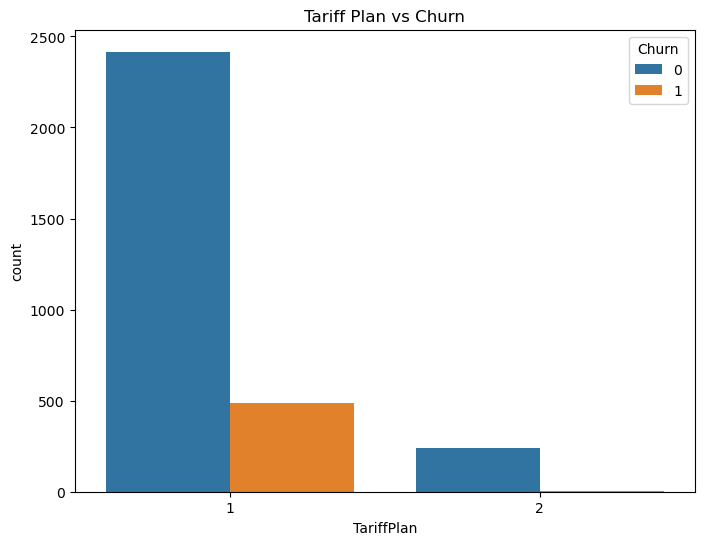

In [10]:
# Bar plot to show relationship between 'Tariff Plan' and 'Churn'
plt.figure(figsize=(8, 6))
sns.countplot(x='TariffPlan', hue='Churn', data=churn)
plt.title('Tariff Plan vs Churn')
plt.show()


The plot above shows that the most subscribed tariff plan (TariffPlan=1) has the highest number of both non-churned and churned customers. While the second  tariff plan (TariffPlan=2) has a significantly lower number of customers.

### 4. Categorical Variables

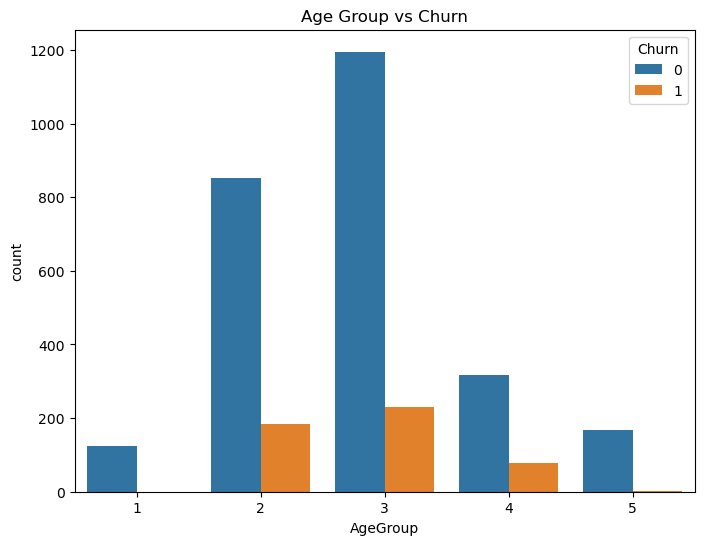

In [11]:
# Analyze 'Age Group' and 'Churn'
plt.figure(figsize=(8, 6))
sns.countplot(x='AgeGroup', hue='Churn', data=churn)
plt.title('Age Group vs Churn')
plt.show()


The bar plot above shows the distribution of churn across different age groups. Age Group 3 has the highest number of customers, followed by Age Group 2. Age Group 3 also has the highest proportion of churned customers.

In [12]:
# Pivot table to summarize relationship between categorical features and churn
pivot_table = pd.pivot_table(churn, index='TariffPlan', columns='Churn', values='ChargeAmount', aggfunc='mean')
print(pivot_table)


Churn              0         1
TariffPlan                    
1           0.916391  0.222904
2           2.686192  0.833333


The pivot table above summarizes the average Charge Amount for each Tariff Plan across churn categories (0 = not churned, 1 = churned). 
__Tariff Plan 1:__

* Customers who have not churned (Churn = 0) have an average Charge Amount of 0.916.
* Customers who have churned (Churn = 1) have an average Charge Amount of 0.223.
This indicates that customers on Tariff Plan 1 who churn tend to have lower charge amounts compared to those who stay.

__Tariff Plan 2:__

* Customers who have not churned have an average Charge Amount of 2.686.
* Customers who have churned have an average Charge Amount of 0.833.
Similar to Tariff Plan 1, customers on Tariff Plan 2 who churn tend to have lower charge amounts.

In summary, across both tariff plans, customers who churn seem to have lower average Charge Amounts compared to those who remain. This suggests that low charges might be a potential indicator of churn.

## Causal Inference and Correlation Analysis

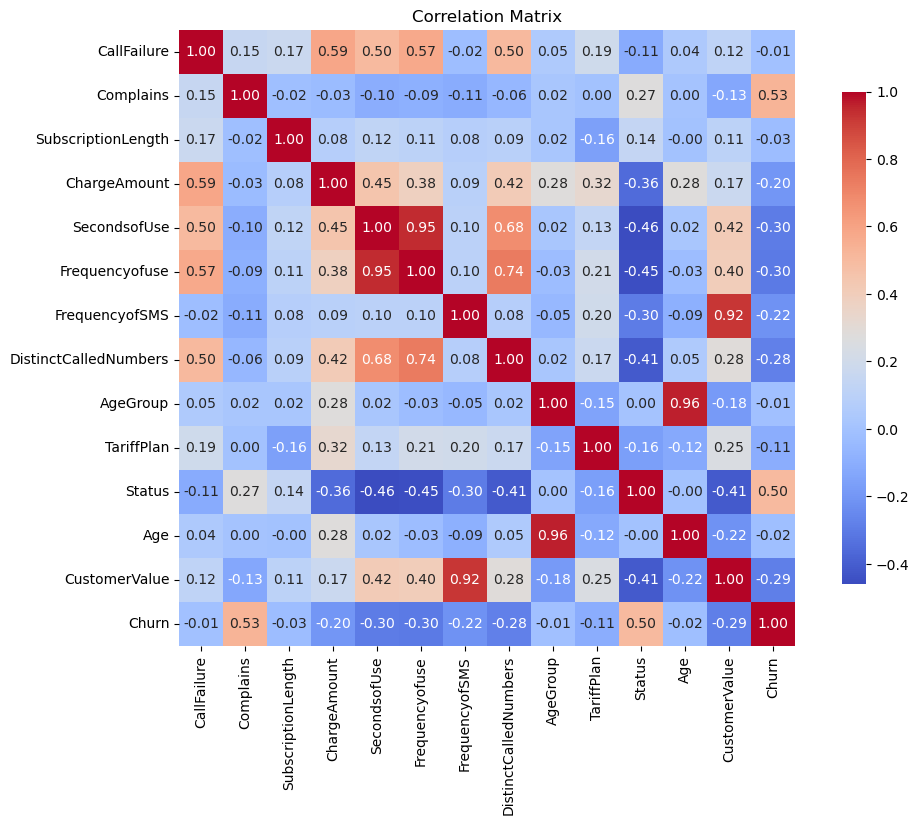

In [13]:
# Step 1: Select relevant features
features = churn[['CallFailure', 'Complains', 'SubscriptionLength', 'ChargeAmount',
       'SecondsofUse', 'Frequencyofuse', 'FrequencyofSMS',
       'DistinctCalledNumbers', 'AgeGroup', 'TariffPlan', 'Status', 'Age',
       'CustomerValue', 'Churn']]

# Step 2: Calculate the correlation matrix
correlation_matrix = features.corr()

# Step 3: Visualize the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, 
            cbar_kws={"shrink": .8})
plt.title('Correlation Matrix')
plt.show()


The correlation value of 0.53 between Complains and Churn indicates a moderate positive correlation between the number of complaints and the likelihood of churn. Higher complaints may suggest dissatisfaction, which could lead to more customers deciding to leave.

A moderate positive correlation between status and churn also suggests that certain statuses are associated with a higher likelihood of churn

#### Group-by Analysis
Since there is a moderate correlation between complains and churn and status and churn, we will analyze the churn rates across different levels of Complains and Status.

In [14]:
# Group-by Analysis for Complains
complain_churn = churn.groupby('Complains')['Churn'].mean().reset_index()
complain_churn['Churn Rate (%)'] = complain_churn['Churn'] * 100

# Group-by Analysis for Status
status_churn = churn.groupby('Status')['Churn'].mean().reset_index()
status_churn['Churn Rate (%)'] = status_churn['Churn'] * 100

# Display results
print("Churn Rate by Complains:")
print(complain_churn)

print("\nChurn Rate by Status:")
print(status_churn)


Churn Rate by Complains:
   Complains     Churn  Churn Rate (%)
0          0  0.101409       10.140942
1          1  0.829876       82.987552

Churn Rate by Status:
   Status     Churn  Churn Rate (%)
0       1  0.052787        5.278716
1       2  0.473146       47.314578


__1. Churn Rate by Complains__

    * For customers who do not lay complains 0, the churn rate is approximately 10.14%.
    * For customers with complain 1, the churn rate jumps significantly to 82.99%.

This indicates that having a complaint greatly increases the likelihood of churn. This suggests that complaints are a strong indicator of customer dissatisfaction, which can lead to churn.


__2. Churn Rate by Status__

    * For Status 1, the churn rate is 5.28%.
    * For Status 2, the churn rate rises to 47.31%.

Customers in Status 2 are more likely to churn compared to those in Status 1. This could suggest that Status 2 might be associated with negative experiences or dissatisfaction.

### Chi-Square Test for Categorical Variables

In [16]:
from scipy.stats import chi2_contingency
alpha = 0.05

# Chi-Square Test for Tariff Plan
contingency_table_tariff = pd.crosstab(churn['TariffPlan'], churn['Churn'])
chi2_tariff, p_tariff, dof_tariff, expected_tariff = chi2_contingency(contingency_table_tariff)

print(f"\nChi-Square Test for Tariff Plan: p-value = {p_tariff}")


Chi-Square Test for Tariff Plan: p-value = 4.928097701198338e-09


In [17]:
# Chi-Square Test for Age Group
contingency_table_age = pd.crosstab(churn['AgeGroup'], churn['Churn'])
chi2_age, p_age, dof_age, expected_age = chi2_contingency(contingency_table_age)

print(f"Chi-Square Test for Age Group: p-value = {p_age}")

Chi-Square Test for Age Group: p-value = 4.8070683032598225e-12


1. The p-value for Tariff plan is extremely low compared to the alpha level of 0.05, indicating a significant association between Tariff Plan and churn. This suggests that different tariff plans may influence whether customers decide to churn or not.

2. Similarly for Age group, the p-value is also very low, suggesting a strong significant association between Age Group and churn. Different age groups appear to have differing propensities to churn.

## Data Preprocessing

#### Transform or scale the skewed features using Box-Cox Transformation

In [18]:
churn.describe()

,CallFailure,Complains,SubscriptionLength,ChargeAmount,SecondsofUse,Frequencyofuse,FrequencyofSMS,DistinctCalledNumbers,AgeGroup,TariffPlan,Status,Age,CustomerValue,Churn
count,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000
mean,7.627937,0.076508,32.541905,0.942857,4472.459683,69.460635,73.174921,23.509841,2.826032,1.077778,1.248254,30.998413,470.972916,0.157143
std,7.263886,0.265851,8.573482,1.521072,4197.908687,57.413308,112.237560,17.217337,0.892555,0.267864,0.432069,8.831095,517.015433,0.363993
min,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,15.000000,0.000000,0.000000
25%,1.000000,0.000000,30.000000,0.000000,1391.250000,27.000000,6.000000,10.000000,2.000000,1.000000,1.000000,25.000000,113.801250,0.000000
50%,6.000000,0.000000,35.000000,0.000000,2990.000000,54.000000,21.000000,21.000000,3.000000,1.000000,1.000000,30.000000,228.480000,0.000000
75%,12.000000,0.000000,38.000000,1.000000,6478.250000,95.000000,87.000000,34.000000,3.000000,1.000000,1.000000,30.000000,788.388750,0.000000
max,36.000000,1.000000,47.000000,10.000000,17090.000000,255.000000,522.000000,97.000000,5.000000,2.000000,2.000000,55.000000,2165.280000,1.000000


In [19]:
churn_scaled = churn.copy()

features_to_transform = ['CallFailure', 'SubscriptionLength', 'ChargeAmount', 
                         'SecondsofUse', 'Frequencyofuse', 'FrequencyofSMS', 
                         'DistinctCalledNumbers', 'Age', 'CustomerValue']

# Apply Box-Cox transformation
for feature in features_to_transform:
    churn_scaled[feature], _ = stats.boxcox(churn_scaled[feature] + 1)  # Adding 1 to avoid issues with zero values

churn_scaled.head()

,CallFailure,Complains,SubscriptionLength,ChargeAmount,SecondsofUse,Frequencyofuse,FrequencyofSMS,DistinctCalledNumbers,AgeGroup,TariffPlan,Status,Age,CustomerValue,Churn
0,2.960927,0,4304.245212,0.0,55.156921,11.233750,1.882565,6.094167,3,1,1,2.031633,11.126729,0
1,0.000000,0,4589.951929,0.0,19.613529,2.610823,2.202402,2.394538,2,1,2,1.974868,6.520047,0
2,3.325030,0,4029.588117,0.0,44.196935,10.358035,6.944878,7.454551,3,1,1,2.031633,21.357779,0
3,3.325030,0,4304.245212,0.0,54.318109,10.846500,0.706464,9.228971,1,1,1,1.799478,11.883055,0
4,1.668148,0,4304.245212,0.0,43.776439,10.188803,1.132316,8.930570,1,1,1,1.799478,10.015851,0


### Logistic Regression
Next, we will train a logistic regression model and examine feature importance.

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Select features and target
X = churn_scaled[['Complains', 'Status', 'ChargeAmount', 'SecondsofUse', 
         'Frequencyofuse', 'TariffPlan', 'SubscriptionLength', 'AgeGroup']]
y = churn_scaled['Churn']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Initialize and fit the model
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

# Make predictions
y_pred = lr_model.predict(X_test)

C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [21]:
# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[520  11]
 [ 47  52]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       531
           1       0.83      0.53      0.64        99

    accuracy                           0.91       630
   macro avg       0.87      0.75      0.79       630
weighted avg       0.90      0.91      0.90       630



In [24]:
importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr_model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

print("\nFeature Importance:")
print(importance)


Feature Importance:
              Feature  Coefficient
0           Complains     3.953938
1              Status     1.488685
6  SubscriptionLength    -0.000140
3        SecondsofUse    -0.006193
4      Frequencyofuse    -0.182433
7            AgeGroup    -0.192079
2        ChargeAmount    -0.324421
5          TariffPlan    -1.018758


### Implementing Random Forest

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

# Create a Random Forest Classifier model
rf_model = RandomForestClassifier(random_state=42)

# Fit the model on the resampled training data
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)

# Generate confusion matrix and classification report
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
class_report_rf = classification_report(y_test, y_pred_rf)

# Display results
print("Random Forest Confusion Matrix:\n", conf_matrix_rf)
print("\nRandom Forest Classification Report:\n", class_report_rf)


Random Forest Confusion Matrix:
 [[525   6]
 [ 23  76]]

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.97       531
           1       0.93      0.77      0.84        99

    accuracy                           0.95       630
   macro avg       0.94      0.88      0.91       630
weighted avg       0.95      0.95      0.95       630



In [26]:
import pandas as pd
feature_importances = pd.DataFrame(rf_model.feature_importances_,
                                   index=X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)


                    importance
SecondsofUse          0.209947
Complains             0.196140
Frequencyofuse        0.190160
SubscriptionLength    0.163248
Status                0.151242
AgeGroup              0.055770
ChargeAmount          0.030051
TariffPlan            0.003442


### Implementing Gradient Boosting

In [27]:
from sklearn.ensemble import GradientBoostingClassifier

# Create a Gradient Boosting Classifier model
gb_model = GradientBoostingClassifier(random_state=42)

# Fit the model on the resampled training data
gb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_gb = gb_model.predict(X_test)

# Generate confusion matrix and classification report
conf_matrix_gb = confusion_matrix(y_test, y_pred_gb)
class_report_gb = classification_report(y_test, y_pred_gb)

# Display results
print("Gradient Boosting Confusion Matrix:\n", conf_matrix_gb)
print("\nGradient Boosting Classification Report:\n", class_report_gb)


Gradient Boosting Confusion Matrix:
 [[520  11]
 [ 27  72]]

Gradient Boosting Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.98      0.96       531
           1       0.87      0.73      0.79        99

    accuracy                           0.94       630
   macro avg       0.91      0.85      0.88       630
weighted avg       0.94      0.94      0.94       630



In [28]:
from sklearn.ensemble import GradientBoostingClassifier
# Assuming you have trained a Gradient Boosting model called `gb_model`
feature_importances_gb = pd.DataFrame(gb_model.feature_importances_,
                                       index=X_train.columns,
                                       columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances_gb)


                    importance
Complains             0.382088
Status                0.185775
SecondsofUse          0.180081
Frequencyofuse        0.128599
SubscriptionLength    0.091912
AgeGroup              0.029519
ChargeAmount          0.001559
TariffPlan            0.000468


#### Insights and Recommendations
__1. Complains:__ This feature is a strong predictor across all models. Reducing complaints can be a key strategy for reducing churn. Customer service improvements or proactive engagement may help.

__2. Status and Tariff Plan:__ The status of customers and their chosen tariff plans play significant roles in predicting churn. You may want to analyze the features associated with these categories to identify which customer segments are more likely to churn and implement retention strategies tailored to those segments.

__3. Usage Patterns:__ The amount of usage (seconds of use and frequency of use) appears to be crucial. Encouraging higher usage may reduce churn, possibly through loyalty programs or usage incentives.

__4. Charge Amount:__ Higher charges are associated with lower churn rates, which could suggest that customers who invest more in your services are more likely to stay. Consider offering tiered pricing or discounts for long-term subscribers.

__5. Age Group and Subscription Length:__ Both features show weaker importance. However, knowing the demographic and subscription behavior can still inform targeted marketing and engagement strategies.

## Model Tuning

Since Random Forest and Gradient Boosting models perform well in the above model development we will perform  hyperparameter tuning for both models to potentially improve performance further.

### Hyperparameter Tuning for Random Forest

In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier


In [50]:
# Define the Model and Parameter Grid

rf = RandomForestClassifier(random_state=42)

param_grid_rf = {
    'n_estimators': [10, 50, 100],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

In [51]:
# Set up Grid Search
grid_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf,
                        scoring='f1', cv=5, n_jobs=-1, verbose=2)

# Fit the model
grid_rf.fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


C:\Users\user\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30, None],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [10, 50, 100]},
             scoring='f1', verbose=2)

In [52]:
#Check Best Parameters and Score
print("Best Parameters:", grid_rf.best_params_)
print("Best Score:", grid_rf.best_score_)


Best Parameters: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best Score: 0.8306739626288498


### Hyperparameter Tuning for Gradient Boosting

In [43]:
from sklearn.ensemble import GradientBoostingClassifier


gb = GradientBoostingClassifier(random_state=42)

param_grid_gb = {
    'n_estimators': [50, 100, 200],  # Number of boosting stages to be run
    'learning_rate': [0.01, 0.05, 0.1],  # Step size for each iteration
    'max_depth': [3, 4, 5],          # Maximum depth of the individual estimators
    'min_samples_split': [2, 5, 10], # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]    # Minimum number of samples required to be at a leaf node
}

In [44]:
# 
grid_gb = GridSearchCV(estimator=gb, param_grid=param_grid_gb,
                        scoring='f1', cv=5, n_jobs=-1, verbose=2)


In [45]:
# Fit the Model
grid_gb.fit(X_train, y_train)  


Fitting 5 folds for each of 243 candidates, totalling 1215 fits


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 4, 5], 'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='f1', verbose=2)

In [46]:
# check Best Parameters and Score

print("Best Parameters:", grid_gb.best_params_)
print("Best Score:", grid_gb.best_score_)


Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}
Best Score: 0.8183668299466381


## Evaluate the Tuned Models

In [53]:
# For Random Forest
best_rf = grid_rf.best_estimator_
rf_predictions = best_rf.predict(X_test)
print("Random Forest Confusion Matrix:")
print(confusion_matrix(y_test, rf_predictions))
print("Random Forest Classification Report:")
print(classification_report(y_test, rf_predictions))

Random Forest Confusion Matrix:
[[525   6]
 [ 21  78]]
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       531
           1       0.93      0.79      0.85        99

    accuracy                           0.96       630
   macro avg       0.95      0.89      0.91       630
weighted avg       0.96      0.96      0.96       630



In [54]:
# For Gradient Boosting
best_gb = grid_gb.best_estimator_
gb_predictions = best_gb.predict(X_test)
print("Gradient Boosting Confusion Matrix:")
print(confusion_matrix(y_test, gb_predictions))
print("Gradient Boosting Classification Report:")
print(classification_report(y_test, gb_predictions))

Gradient Boosting Confusion Matrix:
[[522   9]
 [ 27  72]]
Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       531
           1       0.89      0.73      0.80        99

    accuracy                           0.94       630
   macro avg       0.92      0.86      0.88       630
weighted avg       0.94      0.94      0.94       630



Based on the evaluation of the two fine tuned models above:

* Random Forest performs slightly better with a higher overall accuracy of 96%, better recall (79% vs. 73%), and a higher F1-score (85% vs. 80%) for the churn class.

* Gradient Boosting has a slightly lower accuracy (94%) and recall for the churn class but performs reasonably well with good precision (89%).

__Conclusion:__ Random Forest seems to be a better model for this problem, particularly since our goal is to minimize false negatives (i.e., to catch more customers likely to churn).

#### Feature Importance Analysis:

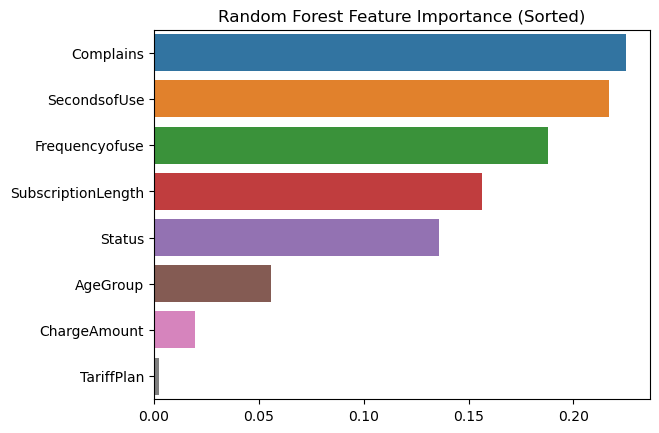

In [57]:
# For Random Forest
importances_rf = best_rf.feature_importances_
features = X_train.columns

# Sort the importances in descending order
indices_rf = np.argsort(importances_rf)[::-1]

# Create sorted feature importance plot
sns.barplot(x=importances_rf[indices_rf], y=features[indices_rf])
plt.title('Random Forest Feature Importance')
plt.show()


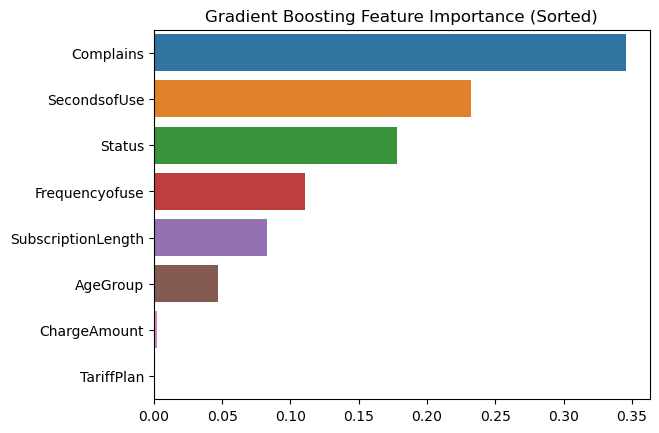

In [58]:
# For Gradient Boosting
importances_gb = best_gb.feature_importances_

# Sort the importances in descending order
indices_gb = np.argsort(importances_gb)[::-1]

# Create sorted feature importance plot
sns.barplot(x=importances_gb[indices_gb], y=features[indices_gb])
plt.title('Gradient Boosting Feature Importance')
plt.show()


__Key Observations:__

1. Complains stands out as the most influential feature in both models, indicating that it has the strongest relationship with churn.
2. Seconds of Use is consistently important across both models, ranking second in both cases.
3. Status is more important in Gradient Boosting (3rd) than in Random Forest (5th).
4. Frequency of Use and Subscription Length maintain high importance in both models.
5. Age Group, Charge Amount, and Tariff Plan are less impactful in both models, with Tariff Plan consistently having the lowest importance

__Insights:__
* The high importance of Complains indicates that customers who submit complaints are much more likely to churn, as also suggested by the high churn rate associated with complaints.

* Seconds of Use and Frequency of Use are also key behavioral indicators for churn prediction.

* Status is notably more important in Gradient Boosting than in Random Forest, suggesting a different interpretation of the customer status feature by the two models.